# Логистическая регрессия

RowNumber — номер строки таблицы;<br/>
CustomerId — идентификатор клиента;<br/>
Surname — фамилия клиента;<br/>
CreditScore — кредитный рейтинг клиента (чем он выше, тем больше клиент брал кредитов и возвращал их);<br/>
Geography — страна проживания клиента (банк межнациональный);<br/>
Gender — пол клиента;<br/>
Age — возраст клиента;<br/>
Tenure — сколько лет клиент пользуется банком;<br/>
Balance — сколько у клиента денег на счетах в банке;<br/>
NumOfProduct — число услуг банка, которые приобрёл клиент;<br/>
HasCrCard — есть ли у клиента кредитная карта (1 — да, 0 — нет);<br/>
IsActiveMember — есть ли у клиента статус активного участника банка (1 — да, 0 — нет);<br/>
EstimatedSalary — предполагаемая заработная плата клиента;<br/>
Exited — статус ушедшего (1 — ушедший клиент, 0 — лояльный клиент).

In [2]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn.model_selection import train_test_split #разделение выборки
from sklearn import preprocessing #предобработка
%matplotlib inline
plt.style.use('seaborn')

In [3]:
churn_data = pd.read_csv('data/churn.csv')
churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


В модуле по визуализации мы выяснили, что отток клиентов в Германии, Франции и Испании имеет различные показатели. Исследователи, которые уже работали с этим датасетом, пришли к выводу, что наилучшее решение при работе с этими данными — строить модели индивидуально для каждой страны. Мы будем прогнозировать отток в немецком филиале банка. Давайте выделим только данные, относящиеся к Германии:

In [4]:
churn_data = churn_data[churn_data['Geography'] == 'Germany']
churn_data.shape

(2509, 14)

Сразу избавимся от заведомо неинформативных признаков: страна, номер строки, идентификатор пользователя и имя клиента.

In [5]:
churn_data = churn_data.drop(['Geography', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,Female,29,4,115046.74,4,1,0,119346.88,1
15,616,Male,45,3,143129.41,2,0,1,64327.26,0
16,653,Male,58,1,132602.88,1,1,0,5097.67,1
26,756,Male,36,2,136815.64,1,1,1,170041.95,0
28,574,Female,43,3,141349.43,1,1,1,100187.43,0


Проверим, что в наших данных нет пропусков:

In [6]:
churn_data.isnull().sum()

CreditScore        0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Давайте расширим наш датасет с помощью методов Feature Engineering. Создадим следующие признаки:<br/>
<br/>
BalanceSalaryRatio — отношение баланса на счетах к заработной плате клиента;<br/>
TenureByAge — отношение времени пользования банком к возрасту клиента;<br/>
CreditScoreGivenAge — отношение кредитного рейтинга к возрасту клиента.

In [7]:
churn_data['BalanceSalaryRatio'] = churn_data['Balance']/churn_data['EstimatedSalary']
churn_data['TenureByAge'] = churn_data['Tenure']/(churn_data['Age'])
churn_data['CreditScoreGivenAge'] = churn_data['CreditScore']/(churn_data['Age'])

Также перекодируем единственный текстовый категориальный признак Gender в бинарный столбец (1 — 'Male', 0 — 'Female'):


In [8]:
churn_data['Gender'] = churn_data['Gender'].apply(lambda x: 1 if x=='Male' else 0)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
7,376,0,29,4,115046.74,4,1,0,119346.88,1,0.963969,0.137931,12.965517
15,616,1,45,3,143129.41,2,0,1,64327.26,0,2.225020,0.066667,13.688889
16,653,1,58,1,132602.88,1,1,0,5097.67,1,26.012449,0.017241,11.258621
26,756,1,36,2,136815.64,1,1,1,170041.95,0,0.804599,0.055556,21.000000
28,574,0,43,3,141349.43,1,1,1,100187.43,0,1.410850,0.069767,13.348837


In [9]:
X = churn_data.drop("Exited", axis=1)
y = churn_data["Exited"]

In [10]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

Прежде чем перейти к этапу разделения выборки на тренировочную и тестовую, посмотрим на сбалансированность данных. Для этого воспользуемся методом value_counts() и выведем количество наблюдений каждого из классов в долевом соотношении от общего количества наблюдений:

In [11]:
y.value_counts(normalize=True)

0    0.675568
1    0.324432
Name: Exited, dtype: float64

Очевидно, что наши классы не сбалансированы. Ушедших пользователей — 32 %, в то время как лояльных — 68 %. 

Нам нужно сделать так, чтобы в тренировочной и тестовой выборках было одинаковое соотношение лояльных и ушедших клиентов. Такое разбиение выборки называется стратифицированным. 

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, random_state=0)

print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


Проверим, что число лояльных и ушедших клиентов примерно одинаково в каждой из выборок:


In [13]:
print('Train :', y_train.value_counts(normalize=True))
print('\n')
print('Test :', y_test.value_counts(normalize=True))

Train : 0    0.675704
1    0.324296
Name: Exited, dtype: float64


Test : 0    0.675159
1    0.324841
Name: Exited, dtype: float64


Обучите модель логистической регрессии на тренировочных данных. Используйте в качестве алгоритма минимизации функции потерь (параметр solver) стохастический градиентный спуск. В качестве значения параметра random_state возьмите 42 для воспроизводимости результатов. Остальные параметры оставьте по умолчанию.<br/><br/>

Предскажите метки классов для тренировочной и тестовой выборок.

In [14]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(random_state=42, solver='sag')
#Обучаем модель, минизируя logloss
log_reg.fit(X_train, y_train)

#Делаем предсказание класса
y_pred_train = log_reg.predict(X_train)
y_pred_test = log_reg.predict(X_test)

In [15]:
print(round(metrics.f1_score(y_train, y_pred_train),2))
print(round(metrics.f1_score(y_test, y_pred_test),2))

0.49
0.47


Сгенерируйте полиномиальные признаки степени 3 для тренировочной и тестовой выборок. Используйте класс PolynomialFeatures из библиотеки sklearn. Параметр include_bias выставите в значение False.
<br/><br/>
Чему равно количество признаков в тренировочной выборке?

In [16]:
#Создаем объект для генерации полиномиальных признаков степени 3
poly = preprocessing.PolynomialFeatures(degree=3, include_bias=False)
#Вычисляем параметры генерации - результирующее количество признак
poly.fit(X_train)
#Производим преобразование для каждой из выборок
X_train_scaled_poly = poly.transform(X_train)
X_test_scaled_poly = poly.transform(X_test)

print('Train shape: {}'.format(X_train_scaled_poly.shape))
print('Test shape: {}'.format(X_test_scaled_poly.shape))

Train shape: (1881, 454)
Test shape: (628, 454)


Обучите модель логистической регрессии на полиномиальных признаках.<br/>
<br/>
Используйте в качестве алгоритма минимизации функции потерь (параметр solver) стохастический градиентный спуск. Параметру random_state выставите значение 42 для воспроизводимости результатов. Увеличьте максимальное количество итераций, выделяемых на сходимость (параметр max_iter), до 1000.
<br/><br/>
Остальные параметры оставьте по умолчанию.
<br/><br/>
Предскажите метки классов для тренировочной и тестовой выборок.
<br/><br/>
Чему равно значение целевой метрики на тренировочной и тестовой выборках для модели, обученной на полиномиальных признаках? Ответ приведите с точностью до двух знаков после точки-разделителя.

In [19]:
#Создаем объект класса логистическая регрессия
log_reg_poly = linear_model.LogisticRegression(random_state=42, solver='sag', max_iter=1000)
#Обучаем модель, минизируя logloss
log_reg_poly.fit(X_train_scaled_poly, y_train)

#Делаем предсказание класса
y_pred_poly_train = log_reg_poly.predict(X_train_scaled_poly)
y_pred_poly_test = log_reg_poly.predict(X_test_scaled_poly)

print(round(metrics.f1_score(y_train, y_pred_poly_train),2))
print(round(metrics.f1_score(y_test, y_pred_poly_test),2))

0.66
0.64


In [20]:
#Считаем вероятности наличия диабета для каждого из пациентов
#Нас интересует только вероятность класса (второй столбец)
y_proba_pred = log_reg_poly.predict_proba(X_test_scaled_poly)[:, 1]
#Для удобства завернем numpy-массив в pandas Series
y_proba_pred = pd.Series(y_proba_pred)
#Создадим списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #Пациентов, для которых вероятность наличия диабета > threshold относим к классу 1
    #В противном случае - к классу 0
    y_pred = y_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y_test, y_pred))
    precision_scores.append(metrics.precision_score(y_test, y_pred))
    f1_scores.append(metrics.f1_score(y_test, y_pred))

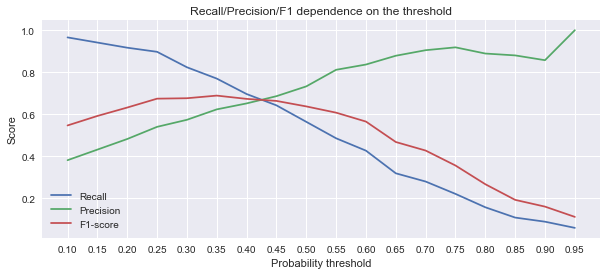

In [21]:
#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')
#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')

#Даем графику название и подписи осям
ax.set_title('Recall/Precision/F1 dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
#Устанавливаем отметки по оси x
ax.set_xticks(thresholds) 
#Отображаем легенду
ax.legend();

In [22]:
#Задаем оптимальный порог вероятностей
threshold_opt = 0.35
#Пациентов, для которых вероятность наличия диабета > 0.4 относим к классу 1
#В противном случае - к классу 0
y_pred_opt = y_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print(metrics.classification_report(y_test, y_pred_opt))

              precision    recall  f1-score   support

           0       0.88      0.78      0.82       424
           1       0.62      0.77      0.69       204

    accuracy                           0.77       628
   macro avg       0.75      0.77      0.76       628
weighted avg       0.79      0.77      0.78       628

